# Walmart - Trip type classification

This use-case deals with the preparation of the data for [Kaggle's Walmart Trip Type Classification competition][1]. It is advised to have a look at the data before starting to work with it.

[1]: https://www.kaggle.com/c/walmart-recruiting-trip-type-classification "Walmart Trip Type classification competition"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from os import getcwd

pd.set_option('notebook_repr_html', True, 'max_columns', 0)
%matplotlib inline

## Getting the data

Each record in the data refers to a single **item**, but since we use the data to predict something about a **trip**, we will construct a data frame with a record per trip. We note that _VisitNumber_ is inuitively the index of the data frame, although it is not unique. So, for the rest of this analysis, unless specified otherwise, the index of the data-frames will be the _VisitNumber_.

In [2]:
train = pd.read_csv(getcwd() + "\\train.csv", 
                    index_col='VisitNumber')
train.columns = ['TripType', 'Weekday', 'UPC', 'ScanCount', 'DepDesc', 'Fineline']
train.index.rename('Visit', inplace=True)
train.head()

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
5,999,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
7,30,Friday,6.053882e+10,1,SHOES,8931.0
7,30,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
8,26,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
8,26,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


> **NOTE:** I changed the names of the index andd some of the columns for better printout.

Since we are going to aggregate many things by _VisitNumber_ it will be useful to evaluate the corresponding GroupBy objects once.

In [3]:
train_grp = train.groupby(level='Visit')

The features _Weekday_ and _DepartmentDescription_ are obviously categorical, so we cast them accordingly.

In [4]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
        'Friday', 'Saturday', 'Sunday']
train['Weekday'] = train['Weekday']\
    .astype('category', categories=days, ordered=True)
train['DepDesc'] = train['DepDesc']\
    .astype('category')

## Data Exploration

### Getting to know the details

#### General information

First we have an overview using the _info()_ method.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647054 entries, 5 to 191347
Data columns (total 6 columns):
TripType     647054 non-null int64
Weekday      647054 non-null category
UPC          642925 non-null float64
ScanCount    647054 non-null int64
DepDesc      645693 non-null category
Fineline     642925 non-null float64
dtypes: category(2), float64(2), int64(2)
memory usage: 25.9 MB


> **Conclusion:** We immediately see there are null entries in the data, but before we deal with that, we would like to further explore the data itself.

#### Unique values

In [6]:
train.apply(pd.Series.nunique)

TripType        38
Weekday          7
UPC          97714
ScanCount       39
DepDesc         68
Fineline      5195
dtype: int64

In [7]:
n_visits = train.index.nunique()
print train.index.nunique(), len(train)

95674 647054


#### Examplary visits

One of the simplest features of any visit (cart) is the amount of items it contains, so we evaluate the proper aggregation and use it for exploring the data.

In [8]:
df_n_items = train_grp['ScanCount'].sum()
df_n_items.head()

Visit
5     -1
7      2
8     28
9      3
10     3
Name: ScanCount, dtype: int64

For inspection purposes we can now find trips with a specific number of items.

In [9]:
for n_items in [50, 20, 1, 0, -1]:
    i_visit = df_n_items.ix[df_n_items == n_items].index[0]
    print "Visit {:4} has {:2} items.".format(i_visit, n_items)

Visit   98 has 50 items.
Visit  274 has 20 items.
Visit   29 has  1 items.
Visit  133 has  0 items.
Visit    5 has -1 items.


Now we can see exemplary visits with different number of items.

In [10]:
train.ix[98].head()

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
98,40,Friday,7.874202e+09,1,DSD GROCERY,3562.0
98,40,Friday,3.400001e+09,1,"CANDY, TOBACCO, COOKIES",78.0
98,40,Friday,7.874201e+09,1,DSD GROCERY,4672.0
98,40,Friday,6.053882e+10,2,SHOES,4815.0
98,40,Friday,7.431255e+09,1,PHARMACY OTC,502.0


In [11]:
train.ix[274].head()

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
274,40,Friday,4.460031e+09,1,LAWN AND GARDEN,31.0
274,40,Friday,6.811311e+10,1,HOUSEHOLD PAPER GOODS,4693.0
274,40,Friday,7.874207e+09,1,HOUSEHOLD PAPER GOODS,6660.0
274,40,Friday,7.874204e+09,2,DSD GROCERY,9220.0
274,40,Friday,5.450019e+09,2,PRE PACKED DELI,7503.0


In [12]:
train.ix[29].head()

TripType               8
Weekday           Friday
UPC              1.2e+09
ScanCount              1
DepDesc      DSD GROCERY
Name: 29, dtype: object

In [13]:
train.ix[133].head()

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
133,999,Friday,9.933894e+09,-1,LADIESWEAR,1180.0
133,999,Friday,9.933894e+09,1,LADIESWEAR,1180.0


In [14]:
train.ix[5].head()

TripType                    999
Weekday                  Friday
UPC                 6.81132e+10
ScanCount                    -1
DepDesc      FINANCIAL SERVICES
Name: 5, dtype: object

### Data visualization

#### _TripType_ frequency

We want to see how the _TripType_ is distributed in the data. Since the _TripType_ is repeated for all the items in a group of _train_\__grp_, we can take only the _TripType_ of the first record. We can do it either by the method _nth()_ or by the method _min()_ (this is not very natural, but it works), so this is a good opportunity to make a short benchmark.

In [15]:
%%timeit
train_grp.nth(0)['TripType'].value_counts()\
    .sort_values(ascending=False)

10 loops, best of 3: 92.7 ms per loop


In [16]:
%%timeit
train_grp['TripType'].min().value_counts()\
    .sort_values(ascending=False)

100 loops, best of 3: 5.29 ms per loop


In [17]:
ttf = train_grp['TripType'].min().value_counts()\
    .sort_values(ascending=False)
ttf.head(5)

8      12161
39      9896
9       9464
999     8444
40      6130
Name: TripType, dtype: int64

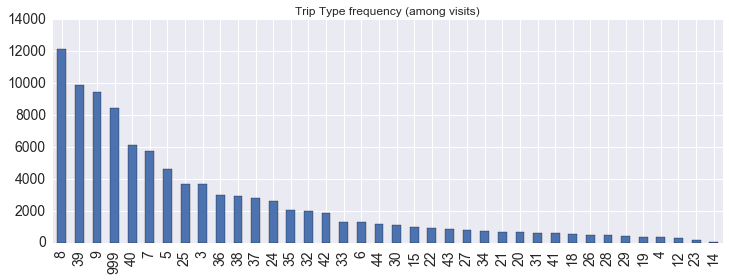

In [18]:
ttf.plot(kind='bar', figsize=(12, 4), fontsize=14, 
         title='Trip Type frequency (among visits)')

#### TripType vs. Departments

We want to see whather there is a relation between the departments of a trip and it type. Note the different conclusions that can be extracted by the different normalizations.

> **NOTE:** We can use the [_hist2d()_][1] method of matplotlib, but this is a good opportunity to explore the [seaborn][2] package, which is widely used lately by data scientist. More specifically we are going to use the [_heatmap()_][3] method.

[1]: http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist2d "hist2d API"
[2]: http://seaborn.pydata.org/ "seaborn homepage"
[3]: http://seaborn.pydata.org/generated/seaborn.heatmap.html "heatmap() API"

In [19]:
tt_vs_dd = pd.crosstab(index=train.TripType, 
                       columns=train.DepDesc, 
                       normalize='index')

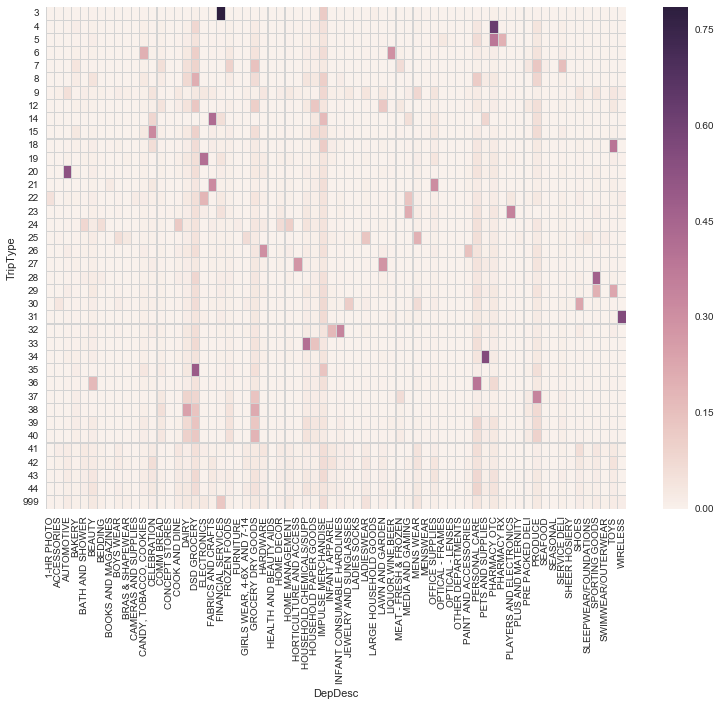

In [20]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(ax=ax, data=tt_vs_dd, 
            linecolor='lightgrey', linewidths=.1)

In [21]:
tt_vs_dd = pd.crosstab(index=train.TripType, 
                       columns=train.DepDesc, 
                       normalize='columns')

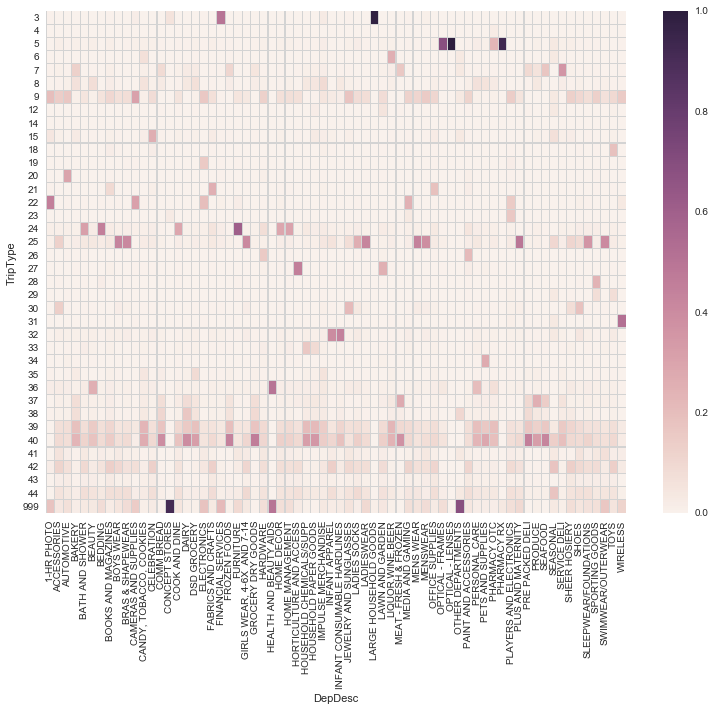

In [22]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(ax=ax, data=tt_vs_dd, 
            linecolor='lightgrey', linewidths=.1)

#### #items frequency

We already saw that the number of items in the cart can vary a lot. In this section we see what are the most common cart sizes and what is their general distribution.

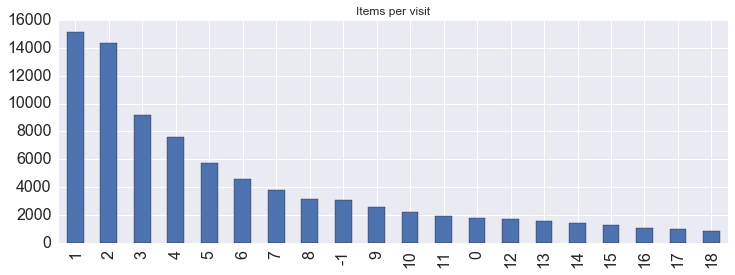

In [23]:
n_items_freq = train_grp['ScanCount'].sum().value_counts()[:20]
n_items_freq.plot(kind='bar', figsize=(12, 4), 
                  fontsize=16, title='Items per visit')

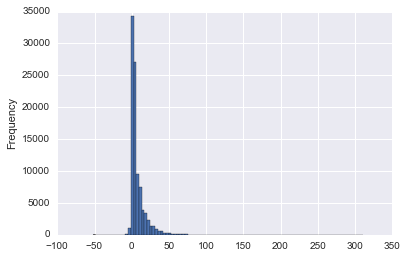

In [24]:
cart_sizes = train_grp['ScanCount'].sum()
cart_sizes.plot(kind='hist', bins=100)
# Try zoom-in with xlim=(-50, 150), ylim=(0, 1000)

In [25]:
print cart_sizes.min(), cart_sizes.max()

-52 311


####  TripType vs. #items

We want to see whether there is any relation between the _TripType_ and the number of items purchased. Since this is a relation between to aggregative features of a visit we start the inspection by applying the proper aggregations per visit.

In [26]:
tt_vs_n_items = train_grp.agg({'TripType': min,
                               'ScanCount': sum})
tt_vs_n_items.head()

,TripType,ScanCount
Visit,,
5,999,-1
7,30,2
8,26,28
9,8,3
10,8,3


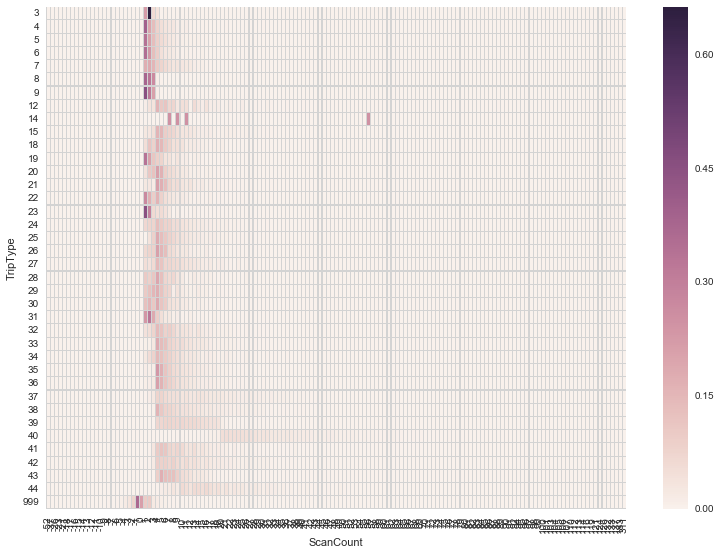

In [27]:
ct_tt_vs_n_items = pd.crosstab(index=tt_vs_n_items.TripType, 
                               columns=tt_vs_n_items.ScanCount, 
                               normalize='index')
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(ax=ax, data=ct_tt_vs_n_items, 
            linecolor='lightgrey', 
            linewidths=.1)

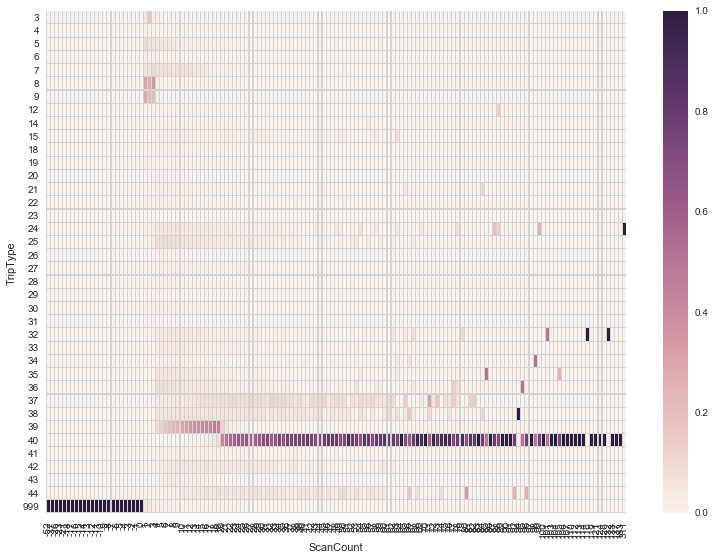

In [28]:
ct_tt_vs_n_items = pd.crosstab(index=tt_vs_n_items.TripType, 
                               columns=tt_vs_n_items.ScanCount, 
                               normalize='columns')
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(ax=ax, data=ct_tt_vs_n_items, 
            linecolor='lightgrey', 
            linewidths=.1)

> **STATUS:** Until now we made no changes in the data, but only examined it.

## Cleaning the data

### Missing values

The _info()_ method showed that some data is missing. Let's see where is the missing data and how does it look.

In [29]:
train.isnull().sum()

TripType        0
Weekday         0
UPC          4129
ScanCount       0
DepDesc      1361
Fineline     4129
dtype: int64

In [30]:
train.ix[train.UPC.isnull()].head()

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
8,26,Friday,NaN,1,NaN,NaN
259,27,Friday,NaN,3,NaN,NaN
259,27,Friday,NaN,1,NaN,NaN
409,999,Friday,NaN,-1,NaN,NaN
479,39,Friday,NaN,1,NaN,NaN


We see that the NAs are not very common, and also that there is a significant overlap between the missing data entries in the different columns. Therefore we decide to drop the records that contain missing data, and we do it with the [_dropna()_][dropna] method.

[dropna]: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna

In [31]:
train.dropna(axis=0, how='any', inplace=True)

In [32]:
print train.index.nunique(), len(train)

94247 642925


After the removal of the missing data, we recreate the GroupBy object.

In [33]:
train_grp = train.groupby(level='Visit')

> **STATUS:** There are no NaNs in the data.

### Duplicated UPCs and returned items

Duplicated UPCs and returned items may correspond to several scenarios:

* **Regular duplications** indicate normal cashier work, in which items with the same UPC are not necessarily processed together.
* **Unique returns** (returns with a unique UPC within a visit) may indicate **planned** trip with an item to be returned.
* **Non-unique returns** may indicate a human "error" (or price check) at the POS (Point of sale).

We now see if there are any _regular_ duplications.

In [34]:
def is_upc_duplicate(visit):
    if -1 in visit.ScanCount.values:
        return False  # returns --> irrelevant duplicate
    else:
        return (visit.UPC.value_counts() > 1).any()

In [35]:
mini_train = train.ix[train.index.unique()[:100], :]
grouped = mini_train\
    .groupby(level='Visit')\
    .apply(is_upc_duplicate)
print grouped.any()

True


The _True_ above proves that our concerns were correct. We can find an example.

In [36]:
grouped[grouped]

Visit
19     True
61     True
86     True
140    True
dtype: bool

In [37]:
train.ix[19]

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
19,42,Friday,7.675336e+09,1,IMPULSE MERCHANDISE,8904.0
19,42,Friday,6.115665e+10,1,JEWELRY AND SUNGLASSES,556.0
19,42,Friday,8.874396e+10,1,MENS WEAR,144.0
19,42,Friday,6.926568e+11,1,FABRICS AND CRAFTS,397.0
19,42,Friday,7.675336e+09,1,IMPULSE MERCHANDISE,8904.0
19,42,Friday,6.953344e+11,1,ACCESSORIES,122.0
19,42,Friday,8.853064e+10,1,MENS WEAR,5201.0
19,42,Friday,8.830961e+10,1,MENS WEAR,5661.0
19,42,Friday,3.181070e+09,1,HOME MANAGEMENT,8124.0


For illustration purposes we can see that 132 is an example of a visit with non-unique returns, but not only, while 333 and 1579 are examples of visits made of non-unique returns only.

In [38]:
train.ix[132]

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
132,9,Friday,6.700886e+09,1,CELEBRATION,6.0
132,9,Friday,6.454161e+10,-1,CELEBRATION,6.0
132,9,Friday,6.454161e+10,2,CELEBRATION,6.0
132,9,Friday,6.700886e+09,-1,CELEBRATION,6.0


In [39]:
train.ix[333]   # See also 1579

,TripType,Weekday,UPC,ScanCount,DepDesc,Fineline
Visit,,,,,,
333,999,Friday,6.565145e+10,1,JEWELRY AND SUNGLASSES,6812.0
333,999,Friday,6.565145e+10,-1,JEWELRY AND SUNGLASSES,6812.0


To eliminate regular duplications we aggregate by the _ScanCount_ of such items. This aggregation is applied to the _ScanCount_ column only, while leaving the other columns unchaged. This can be done by indexing manipulation.

In [40]:
temp = train.groupby([train.index, 'UPC', 'Weekday', 'DepDesc',
                      'Fineline', 'TripType'])['ScanCount'].sum()
temp.head()

Visit  UPC           Weekday  DepDesc                Fineline  TripType
5      6.811315e+10  Friday   FINANCIAL SERVICES     1000.0    999        -1
7      7.410811e+09  Friday   PERSONAL CARE          4504.0    30          1
       6.053882e+10  Friday   SHOES                  8931.0    30          1
8      2.006614e+09  Friday   PAINT AND ACCESSORIES  1017.0    26          1
                                                               26          2
Name: ScanCount, dtype: int64

In [41]:
train = temp.reset_index(['UPC', 'Weekday', 'DepDesc',
                          'Fineline', 'TripType'])
train.head()

,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
5,6.811315e+10,Friday,FINANCIAL SERVICES,1000.0,999,-1
7,7.410811e+09,Friday,PERSONAL CARE,4504.0,30,1
7,6.053882e+10,Friday,SHOES,8931.0,30,1
8,2.006614e+09,Friday,PAINT AND ACCESSORIES,1017.0,26,1
8,2.006614e+09,Friday,PAINT AND ACCESSORIES,1017.0,26,2


We note that this aggregation also created records with _ScanCount = 0_, which reflect items that were scanned and cancelled by the cashier (e.g. check the price, regret, mistake, etc.). For illustration purposes we can look again at visits 132, 333 and 1579 to see how the aggregation influenced them.

In [42]:
train.ix[132]

,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
132,6.700886e+09,Friday,CELEBRATION,6.0,9,0
132,6.454161e+10,Friday,CELEBRATION,6.0,9,1


In [43]:
train.ix[333]

UPC                     6.56514e+10
Weekday                      Friday
DepDesc      JEWELRY AND SUNGLASSES
Fineline                       6812
TripType                        999
ScanCount                         0
Name: 333, dtype: object

In [44]:
train.ix[1579]

,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
1579,5.027695e+09,Friday,HOME DECOR,856.0,999,0
1579,8.280307e+09,Friday,HOME DECOR,856.0,999,0
1579,6.442257e+10,Friday,PHARMACY OTC,509.0,999,0


After combining duplicated items, we have fewer records, but the same number of visits. Anyway we recreate the GroupBy object.

In [45]:
print train.index.nunique(), len(train)

94247 628483


In [46]:
train_grp = train.groupby(level='Visit')

We assume that visits which contain only _ScanCount_ of 0 carry no information and we omit them. For illustration purposes we first have a look on some of the visits we are filtering out.

In [47]:
mini_train = train.ix[train.index.unique()[:1000], :]
grouped = mini_train.groupby(level='Visit')
sc_0_only = grouped.filter(lambda grp: (grp.ScanCount == 0).all())
sc_0_only

,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
333,6.565145e+10,Friday,JEWELRY AND SUNGLASSES,6812.0,999,0
685,7.013201e+09,Friday,GROCERY DRY GOODS,2996.0,999,0
781,2.471911e+09,Friday,HORTICULTURE AND ACCESS,8294.0,999,0
1120,7.149518e+10,Friday,WIRELESS,1590.0,999,0
1460,2.471922e+09,Friday,HORTICULTURE AND ACCESS,8615.0,999,0
1579,5.027695e+09,Friday,HOME DECOR,856.0,999,0
1579,8.280307e+09,Friday,HOME DECOR,856.0,999,0
1579,6.442257e+10,Friday,PHARMACY OTC,509.0,999,0
1783,6.030842e+10,Friday,PERSONAL CARE,5300.0,999,0


> **NOTE:** The _TripType_ of such trips is 999. We can call this kind of visits **cashier_check**, since we assume this is the origin of such visits. This will be important when we will build the classification model in the future. We can run the line _sc_\__0_\__only.TripType.value_\__counts()_ for illustration of this fact.

And now the actual filtration...

In [48]:
train = train_grp.filter(lambda grp: (grp.ScanCount != 0).any())

> **NOTE:** For some reason, _filter()_ is very slow...

In [49]:
print train.index.nunique(), len(train)

93154 626968


> **STATUS:** At this stage there are no NaNs, no duplicted UPCs and all returns are unique returns.

After the removal of the missing data, we recreate the GroupBy object.

In [50]:
train_grp = train.groupby(level='Visit')

#### _TripType = 999_

We naturally believe that _TripType_ 999 has irregular structure, and therefore it is advised to understand its content. Moreover, even after filtering many of the visits with _TripType 999_, it is still representing, as illustrated below, nearly 8% of the visits. For this analysis we introduce the _train999_ data frame.

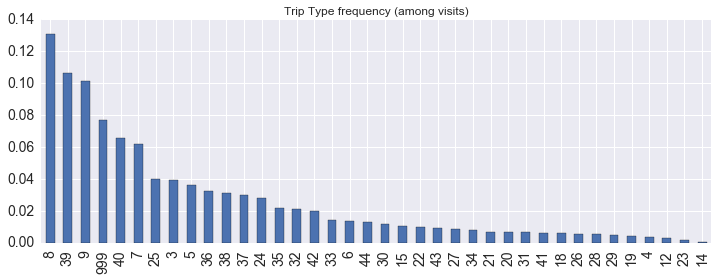

In [51]:
ttf = train_grp['TripType'].min().value_counts(normalize=True)\
    .sort_values(ascending=False)
ttf.plot(kind='bar', figsize=(12, 4), fontsize=14, 
         title='Trip Type frequency (among visits)')

In [52]:
train999 = train.ix[train.TripType == 999]
train999.head()  # Look at 20

,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
5,6.811315e+10,Friday,FINANCIAL SERVICES,1000.0,999,-1
133,9.933894e+09,Friday,LADIESWEAR,1180.0,999,1
133,9.933894e+09,Friday,LADIESWEAR,1180.0,999,-1
182,5.473282e+09,Friday,HARDWARE,8410.0,999,-1
190,4.316875e+09,Friday,HARDWARE,4513.0,999,-1


We see several types of 999 visits:

* Unique returns
    * No replacement, e.g. 182, 190, 261, 400
    * Item replacement, e.g. 133
* Financial services
    * Negative, e.g. 5, 253, 281, 317
    * Positive, e.g. 351, 357
* Regular (or not?) visits, e.g. 207, 295

We test their "confidence" one by one, to see whether the other direction works (e.g. whether the mere presence of unique returns indicate _TripType_ 999)

##### Unique returns

At this stage all returns are unique returns ,so we can exanime the _TripType_ associated with them.

In [53]:
unique_returns_cnt = train.ix[train.ScanCount < 0]\
    .TripType.value_counts()
print unique_returns_cnt

999    7632
7         2
39        1
35        1
38        1
22        1
29        1
44        1
40        1
8         1
Name: TripType, dtype: int64


**Conclusion \#1:** If a visit has a unique return, then we can predict that its _TripType_ is 999.

This means that we can ignore visits which include unique returns and deal with them (namely, classify such visits) separately.

In [54]:
# train = train_grp.filter(lambda grp: (grp.ScanCount>0).all())

In [55]:
visits_with_returns = train.ix[train.ScanCount<0]
print visits_with_returns.index.nunique(), len(visits_with_returns)
train.drop(visits_with_returns.index.unique(), inplace=True)

5157 7642


> **NOTE:** The (commented) filtration implementation is more natural, but it looks like _filter()_ is not very fast...

In [56]:
print train.index.nunique(), len(train)

87997 617547


> **NOTE:** 626968 != 617547 + 7642 because some visits include unique returns AND other items.

Again, after the filtration we recreate the GroupBy object.

In [57]:
train_grp = train.groupby(level='Visit')

> **STATUS:** At this stage there are no NaNs, no duplicted UPCs and no returns ($\rightarrow$ all _ScanCount_ values are greater than 0).

##### Financial services (regardless of _TripType = 999_)

We first create a dataframe with only the records of the financial service data.

In [58]:
df_fs = train.ix[train.DepDesc == 'FINANCIAL SERVICES']
print df_fs.shape
df_fs.head()

(9452, 6)


,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
106,6.053890e+10,Friday,FINANCIAL SERVICES,276.0,3,1
106,6.811316e+10,Friday,FINANCIAL SERVICES,275.0,3,1
121,6.811316e+10,Friday,FINANCIAL SERVICES,278.0,3,1
121,6.811316e+10,Friday,FINANCIAL SERVICES,277.0,3,1
153,6.053889e+10,Friday,FINANCIAL SERVICES,285.0,3,1


We note that the information in the _rows_ and the information in the _visits_ is not the same.

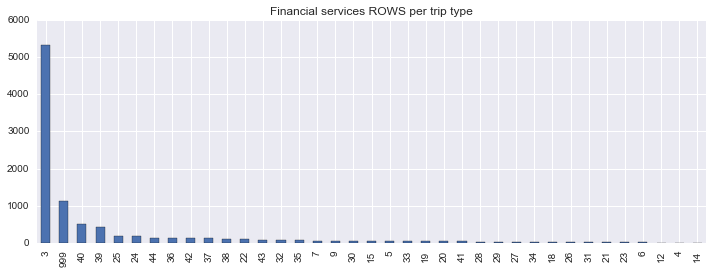

In [59]:
df_fs['TripType'].value_counts()\
    .plot(kind='bar', figsize=(12, 4),
          title='Financial services ROWS per trip type')

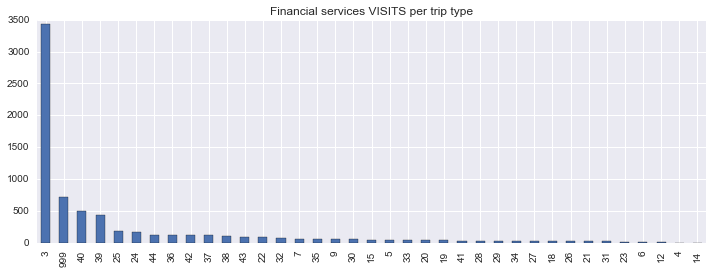

In [60]:
grouped = df_fs.groupby(level='Visit')
grouped['TripType'].min().value_counts()\
    .plot(kind='bar', figsize=(12, 4),
          title='Financial services VISITS per trip type')

What is the difference between visits that include the _DepartmentDescription_ FINANCIAL SERVICES, but have different _TripType_ values?

In [61]:
fs_rows_tt3 = df_fs.ix[df_fs.TripType == 3]
train.ix[fs_rows_tt3.index.unique()[::1000]] # Look at step=100

,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
106,6.053890e+10,Friday,FINANCIAL SERVICES,276.0,3,1
106,6.811316e+10,Friday,FINANCIAL SERVICES,275.0,3,1
46274,6.053882e+10,Friday,FINANCIAL SERVICES,1000.0,3,1
46274,8.303240e+10,Friday,IMPULSE MERCHANDISE,1001.0,3,1
101274,6.053889e+10,Sunday,FINANCIAL SERVICES,285.0,3,1
101274,6.811311e+10,Sunday,FINANCIAL SERVICES,200.0,3,1
164572,6.053882e+10,Wednesday,FINANCIAL SERVICES,1000.0,3,1
164572,6.811318e+10,Wednesday,FINANCIAL SERVICES,283.0,3,1


In [62]:
fs_rows_tt999 = df_fs.ix[df_fs.TripType == 999]
train.ix[fs_rows_tt999.index.unique()[::200]] # Look at step=100

,UPC,Weekday,DepDesc,Fineline,TripType,ScanCount
Visit,,,,,,
351,6.811318e+10,Friday,FINANCIAL SERVICES,281.0,999,1
351,6.811318e+10,Friday,FINANCIAL SERVICES,280.0,999,1
40596,6.811318e+10,Thursday,FINANCIAL SERVICES,281.0,999,1
40596,6.811318e+10,Thursday,FINANCIAL SERVICES,280.0,999,1
92387,2.519222e+09,Friday,MEDIA AND GAMING,9257.0,999,1
92387,2.724289e+09,Friday,ELECTRONICS,4294.0,999,0
92387,4.141942e+09,Friday,IMPULSE MERCHANDISE,808.0,999,1
92387,6.053880e+10,Friday,FINANCIAL SERVICES,3903.0,999,0
156965,6.053881e+10,Tuesday,IMPULSE MERCHANDISE,1001.0,999,1


We see that _TripType = 3_ and _TripType=999_ are very similar when it comes to Financial Services, so how can we distinguish between them? We can use the _FinelineNumber_!

#### Illustration 1

In [63]:
d_fs_tt = {}  # {TripType: Fineline value counts (Series)}
for tt in df_fs.TripType.unique():
    df_fs_tt = df_fs.ix[df_fs.TripType == tt]
    d_fs_tt[tt] = df_fs_tt.Fineline.value_counts()

In [64]:
df_fl = pd.DataFrame(d_fs_tt).transpose()
df_fl.head().iloc[:, :10]

,0.0,200.0,275.0,276.0,277.0,278.0,280.0,281.0,282.0,283.0
3,805.0,282.0,691.0,691.0,829.0,829.0,NaN,NaN,35.0,427.0
4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


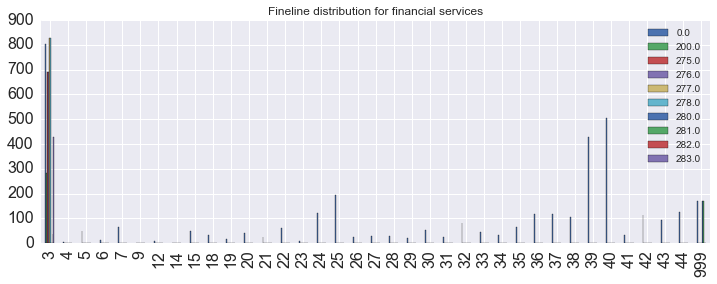

In [65]:
df_fl_sample = df_fl.iloc[:, :10]
df_fl_sample.plot(kind='bar', figsize=(12, 4), fontsize=16,
                  title='Fineline distribution for financial services')

#### Illustration 2

In [66]:
df_fs_fl = pd.crosstab(index=df_fs.TripType, 
                       columns=df_fs.Fineline, 
                       normalize='columns')
df_fs_fl.head().iloc[:, :10]

Fineline,0.0,200.0,275.0,276.0,277.0,278.0,280.0,281.0,282.0,283.0
TripType,,,,,,,,,,
3,0.216223,1.0,0.995677,0.995677,1.0,1.0,0.0,0.0,1.0,1.0
4,0.001343,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.013430,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.003492,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.017459,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


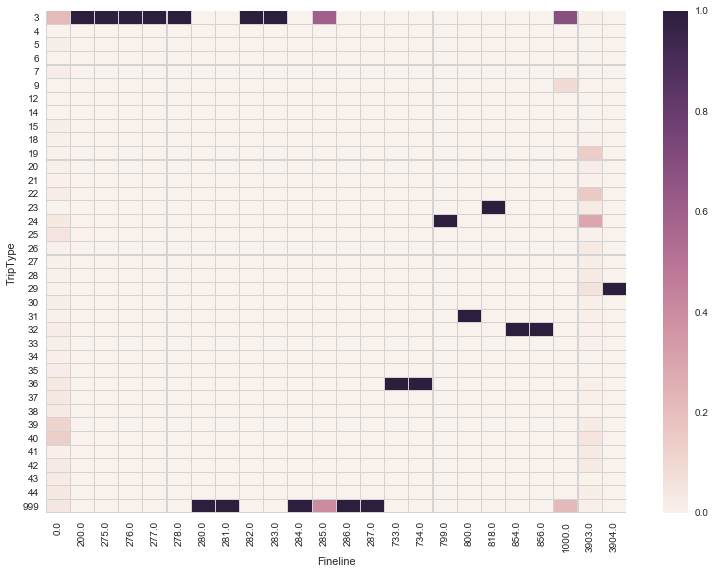

In [67]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(ax=ax, data=df_fs_fl, 
            linecolor='lightgrey', 
            linewidths=.1)

**Conclusion \#2:** We note that the data frame _fs_\__fl_ is actually the classification probabilities for visits with financial services.

#### Decisive Fineline numbers

So there are _FinelineNumber_ values that give nearly 100% prediction of the _TripType_ while others do not. 

In [68]:
print df_fs_fl.columns

Float64Index([   0.0,  200.0,  275.0,  276.0,  277.0,  278.0,  280.0,  281.0,
               282.0,  283.0,  284.0,  285.0,  286.0,  287.0,  733.0,  734.0,
               799.0,  800.0,  818.0,  854.0,  856.0, 1000.0, 3903.0, 3904.0],
             dtype='float64', name=u'Fineline')


In [69]:
decisive_fl = [fl for fl in df_fs_fl.columns 
               if df_fs_fl[fl].max() > 0.99]
print decisive_fl

[200.0, 275.0, 276.0, 277.0, 278.0, 280.0, 281.0, 282.0, 283.0, 284.0, 286.0, 287.0, 733.0, 734.0, 799.0, 800.0, 818.0, 854.0, 856.0, 3904.0]


In [70]:
non_decisive_fl = [fl for fl in df_fs_fl.columns 
                   if df_fs_fl[fl].max() <= 0.99]
print non_decisive_fl

[0.0, 285.0, 1000.0, 3903.0]


For classification purposes we can drop visits with decisive _FinelineNumber_.

In [71]:
df_decisive = df_fs.ix[df_fs.Fineline.isin(decisive_fl)]
train.drop(df_decisive.index.unique(), inplace=True)

In [72]:
print train.index.nunique(), len(train)

85339 612510


> **STATUS:** At this stage there are no NANs, no duplicate UPCs, no unique returns (999), and no visits with FINANCIAL SERVICES which have _FinelineNumber_ other than 0, 285, 1000 or 3903.

In [73]:
train_grp = train.groupby(level='Visit')

## Final dataset assembly

In this part we create the features that will be used by the model. Each feature(s) will be presented by a dataframe indexed by the _VisitNumber_, and at the end all of these data frames will be merged together. Along the preprocessing we've dropped visits that can be ignored by the (future) classification model, so we can now think of more "business-oriented" features .

The following features will be considered:

* deps - number of items from each department (68 new features)
* n_departments - the number of unique departments represented in the cart
* n_items - the number of items in the cart
* n_upcs - the number of unique UPCs in the cart
* common_dep - the most common department within the visit
* TripType - dahh...

### Items per department (_df_\__deps_)

In [74]:
df_deps = pd.pivot_table(data=train,
                         values='ScanCount', 
                         index=train.index, 
                         columns='DepDesc', 
                         aggfunc=np.sum, 
                         fill_value=0)
df_deps.columns = df_deps.columns.astype(str)  # Otherwise we get CategoricalIndex
df_deps.head().iloc[:, ::10]

DepDesc,1-HR PHOTO,CAMERAS AND SUPPLIES,FINANCIAL SERVICES,HOUSEHOLD CHEMICALS/SUPP,"LIQUOR,WINE,BEER",PERSONAL CARE,SERVICE DELI
Visit,,,,,,,
7,0,0,0,0,0,1,0
8,0,0,0,1,0,0,0
9,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0


### Number of departments (_df_\__n_\__deps_)

We can use the latest _df_\__deps_ in order to evaluate the number of unique departments within a visit. The aggregation returns a _Series_ object, which we will not be able to concat with _df_\__deps_, so we make it a one-column _DataFrame_.

In [75]:
df_n_deps = pd.DataFrame(df_deps.astype(bool).sum(axis=1), 
                         columns=['n_deps'], 
                         index=df_deps.index)
df_n_deps.head()

,n_deps
Visit,
7,2
8,6
9,2
10,2
11,3


### Number of items (_df_\__n_\__items_)

For this task also we can use the latest _df_\__deps_.

In [76]:
df_n_items = pd.DataFrame(df_deps.sum(axis=1), 
                          columns=['n_items'], 
                          index=df_deps.index)
df_n_items.head()

,n_items
Visit,
7,2
8,27
9,3
10,3
11,4


### Number of UPCs (_df_\__n_\__upcs_)

In [77]:
df_n_upcs = pd.DataFrame(train_grp['UPC'].nunique().values, 
                         columns=['n_upcs'], 
                         index=df_deps.index)
df_n_upcs.head()

,n_upcs
Visit,
7,2
8,20
9,3
10,3
11,4


> **NOTE:** The need for the _.values_ attribute is due to the index that is added to the Series due to the groupby operation.

### Weekday

In [78]:
df_weekday = pd.DataFrame(train_grp['Weekday'].min(), 
                          columns=['Weekday'], 
                          index=df_deps.index)
df_weekday.head()

,Weekday
Visit,
7,Friday
8,Friday
9,Friday
10,Friday
11,Friday


In [79]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
        'Friday', 'Saturday', 'Sunday']
df_weekday['Weekday'] = df_weekday['Weekday']\
    .astype('category', categories=days, ordered=True)

### _TripType_

In [80]:
df_trip_type = pd.DataFrame(train_grp['TripType'].min(), 
                            columns=['TripType'], 
                            index=df_deps.index)
df_trip_type.head()

,TripType
Visit,
7,30
8,26
9,8
10,8
11,35


### Put it all together

In [81]:
data = pd.concat((df_deps, df_n_deps, df_n_items, 
                  df_n_upcs, df_weekday, df_trip_type), 
                 axis=1)
data.head().iloc[:, ::10]

,1-HR PHOTO,CAMERAS AND SUPPLIES,FINANCIAL SERVICES,HOUSEHOLD CHEMICALS/SUPP,"LIQUOR,WINE,BEER",PERSONAL CARE,SERVICE DELI,n_upcs
Visit,,,,,,,,
7,0,0,0,0,0,1,0,2
8,0,0,0,1,0,0,0,20
9,0,0,0,0,0,0,0,3
10,0,0,0,0,0,0,0,3
11,0,0,0,0,0,0,0,4


### Export the result

In [82]:
data.to_csv(getcwd() + "\\triptype final data.csv")